In [1]:
import numpy as np

class LassoHomotopyModel:
    def __init__(self,
                 lambda_max=None,
                 lambda_min=1e-4,
                 step_size=0.9,
                 max_iter=1000,
                 fit_intercept=True):
        """
        Parameters
        ----------
        lambda_max : float, optional
            Starting value of lambda for your homotopy iteration.
            If None, it will be computed from data.
        lambda_min : float
            Minimum value of lambda at which to stop.
        step_size : float
            Factor to reduce lambda each iteration (homotopy approach).
        max_iter : int
            Maximum number of iterations in your solver loop.
        fit_intercept : bool
            If True, automatically adds a column of 1s to X to learn an intercept.
        """
        self.lambda_max = lambda_max
        self.lambda_min = lambda_min
        self.step_size = step_size
        self.max_iter = max_iter
        self.fit_intercept = fit_intercept
        self.coefficients = None
        self._n_features = None

    def fit(self, X, y):
        """
        Fits the LASSO model using a simple iterative (ISTA-like) approach with
        homotopy-based reduction of lambda.

        X is a 2D array of shape [n_samples, n_features].
        y is a 1D array of shape [n_samples].
        """
        # Keep original shapes
        n_samples, n_features = X.shape
        self._n_features = n_features

        # If requested, add a column of ones for the intercept
        if self.fit_intercept:
            X = np.hstack([X, np.ones((n_samples, 1))])
            n_features = n_features + 1  # There's now an extra feature (the intercept)

        # Initialize coefficients
        self.coefficients = np.zeros(n_features)

        # If no lambda_max is given, set it so that the first gradient step is feasible
        if self.lambda_max is None:
            # typical way for LASSO: max(|X.T @ y|) / n_samples
            self.lambda_max = np.max(np.abs(X.T @ y)) / n_samples

        # Decide on a stable learning rate using an approximation of the largest eigenvalue of X^T X
        # The largest eigenvalue can be approximated by the square of the 2-norm of X
        largest_eig_approx = np.linalg.norm(X, 2) ** 2
        learning_rate = 1.0 / largest_eig_approx

        lambda_current = self.lambda_max

        for iteration in range(self.max_iter):
            # Stop if lambda is below the minimum threshold
            if lambda_current < self.lambda_min:
                break

            # Compute residual and gradient
            # residual = y - X @ coef
            residual = y - X @ self.coefficients
            gradient = (X.T @ residual) / n_samples  # size: [n_features]

            # Take a gradient step
            updated = self.coefficients + learning_rate * gradient

            # Soft-threshold the result
            # Note: we multiply lambda by learning_rate as per ISTA formula
            self.coefficients = self._soft_threshold(updated, lambda_current * learning_rate)

            # Decay lambda for next iteration
            lambda_current *= self.step_size

        return LassoHomotopyResults(self.coefficients, self.fit_intercept, self._n_features)

    def _soft_threshold(self, z, threshold):
        """Soft-thresholding operator."""
        return np.sign(z) * np.maximum(np.abs(z) - threshold, 0.0)


class LassoHomotopyResults:
    def __init__(self, coefficients, fit_intercept, original_n_features):
        """
        Parameters
        ----------
        coefficients : np.ndarray
            The fitted coefficients, possibly including intercept if fit_intercept=True.
        fit_intercept : bool
            Whether an intercept term was included.
        original_n_features : int
            Number of original features (excluding intercept).
        """
        self.coefficients = coefficients
        self.fit_intercept = fit_intercept
        self.original_n_features = original_n_features

    def predict(self, X):
        """
        Predict using the trained coefficients.

        If fit_intercept is True, we assume the last coefficient is the intercept.
        """
        if self.fit_intercept:
            # Add a column of ones for intercept
            n_samples = X.shape[0]
            X = np.hstack([X, np.ones((n_samples, 1))])

        return X @ self.coefficients

In [3]:
%run tests/test_LassoHomotopy.py

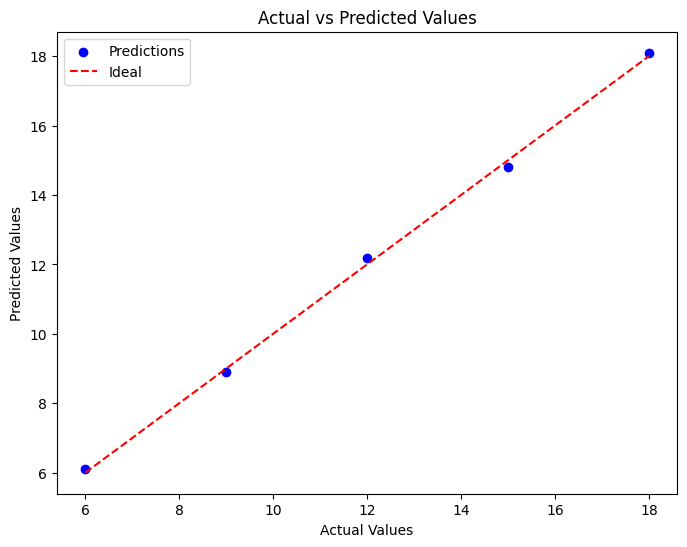

In [4]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, color='blue', label='Predictions')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label='Ideal')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.legend()
    plt.show()

# Example usage
y_true = [6.0, 9.0, 12.0, 15.0, 18.0]
y_pred = [6.1, 8.9, 12.2, 14.8, 18.1]  # Replace with actual predictions
plot_predictions(y_true, y_pred)

In [5]:
# Run test cases
test_predict()
test_collinearity()
test_irrelevant_feature()
test_all_zero_feature()
test_extreme_collinearity()

X shape: (1000, 10)
y shape: (1000,)
Coefficients: [ 0.03365819  0.01023585 -0.00053878  0.04439919  0.04306971  0.04619478
  0.04733769  0.03890747 -0.00229783  0.0016497  -0.00154549]
Noisy feature coefficient: 0.0162
Collinear coefficients: [np.float64(0.0641873791876383), np.float64(0.0641873791876383)]
